#Detecting Antisemitism on Social Media

##Install libraries and dependencies

In [ ]:
# install libraries
!pip install datasets evaluate transformers[sentencepiece]
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
# import packages
from datasets import load_dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from transformers import pipeline, AdamW, get_scheduler
import torch
from tqdm.auto import tqdm
import evaluate
from matplotlib import pyplot as plt
import time
from datasets import DatasetDict, Dataset
from torch.utils.data import DataLoader



In [ ]:
# Mount your own google drive to Colab
from google.colab import drive
drive.mount('/content/gdrive')
import sys, csv, pandas as pd
sys.path.append('/content/drive/MyDrive/PSYCH186B/FINAL_PROJECT/PSYCH_186B_Final_Project_Detecting_Antisemitism_Online/Jupyter_notebooks_of_github_files')

Mounted at /content/gdrive


# Model 1

[Antisemitism model from Hugging Face](https://huggingface.co/astarostap/autonlp-antisemitism-2-21194454)
<br>
[Dataset that the model was trained on](https://huggingface.co/datasets/astarostap/autonlp-data-antisemitism-2)

Performance metrics of initial Hugging Face model:


*   Loss: 0.529
*   Accuracy: 0.757
*   Recall/Sensitivity: 0.836


In [ ]:
# load dataset
raw_datasets = load_dataset("ISCA-IUB/AntisemitismOnTwitter")

In [ ]:
# select only columns 'Label' and 'Text
label = raw_datasets['train']['Biased']
text = raw_datasets['train']['Text']

df = pd.DataFrame({'label': label, 'Text': text})

In [ ]:
# create train/test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.128, random_state=42) # i don't really know what this is doing

##Loading and Preprocessing Data with load_data

In [ ]:
def load_data(train_df, val_df, test_df):
  combined_datasets = DatasetDict()
  # create datasets for train and test
  train_data = Dataset.from_pandas(train_df)
  test_data = Dataset.from_pandas(test_df)
  val_data = Dataset.from_pandas(val_df)

  # add train and test datasets to the DatasetDict
  combined_datasets['train'] = train_data
  combined_datasets['test'] = test_data
  combined_datasets['val'] = val_data

  # print the structure of the DatasetDict
  print(combined_datasets)

  # test dataset dimensions
  train_label_dim = np.shape(combined_datasets['train']['label'])
  print(f'Train label dim: {train_label_dim}')
  test_text_dim = np.shape(combined_datasets['train']['Text'])
  print(f'Test text dim: {test_text_dim}')

  # remove the '__index_level_0__' feature from datasets
  combined_datasets['train'] = combined_datasets['train'].remove_columns('__index_level_0__')
  combined_datasets['test'] = combined_datasets['test'].remove_columns('__index_level_0__')
  combined_datasets['val'] = combined_datasets['val'].remove_columns('__index_level_0__')

  # print the updated dataset information
  print(combined_datasets)

  return combined_datasets

##Load model

In [ ]:
model = "astarostap/autonlp-antisemitism-2-21194454"

def load_model(model):
  # use a pipeline as a high-level helper
  pipe = pipeline("text-classification", model = model)

  def tokenize_function(example):
    return tokenizer(example["Text"], truncation=True)

  tokenizer = AutoTokenizer.from_pretrained(model)
  tokenized_datasets = df.map(tokenize_function, batched = True)
  data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  model = AutoModelForSequenceClassification.from_pretrained(model)

  return tokenized_datasets, model, data_collator

In [ ]:
raw_datasets=combined_datasets

In [ ]:
tokenized_datasets['train']

In [ ]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    #higher metrics is better for all of these [0,1]
    recall = evaluate.load("recall")
    recall_metric = recall.compute(predictions=predictions, references=labels)
    f1 = evaluate.load("f1")
    f1_metric = f1.compute(predictions=predictions, references=labels)
    precision = evaluate.load("precision")
    precision_metric = precision.compute(predictions=predictions, references=labels)
    acc = evaluate.load("accuracy")
    acc_metric = acc.compute(predictions=predictions, references=labels)

    return {'recall': recall_metric, 'f1': f1_metric, 'precision': precision_metric, 'accuracy': acc_metric}

training_args = TrainingArguments("test-trainer", evaluation_strategy="epoch")

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
start = time.time()

trainer.train()

end = time.time()
runtime = end-start
print('Total runtime for 3 epochs: ', runtime)

Epoch,Training Loss,Validation Loss,Recall,F1,Precision,Accuracy
1,0.064600,0.843140,{'recall': 0.6188524590163934},{'f1': 0.6894977168949772},{'precision': 0.7783505154639175},{'accuracy': 0.9020878329733621}
2,0.042100,0.712564,{'recall': 0.6188524590163934},{'f1': 0.7139479905437353},{'precision': 0.8435754189944135},{'accuracy': 0.9128869690424766}
3,0.006400,0.820341,{'recall': 0.680327868852459},{'f1': 0.6974789915966386},{'precision': 0.7155172413793104},{'accuracy': 0.896328293736501}


Checkpoint destination directory test-trainer/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128}
Trainer is attempting to log a value of "{'recall': 0.6188524590163934}" of type <class 'dict'> for key "eval/recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.6894977168949772}" of type <class 'dict'> for key "eval/f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.77835

Total runtime for 3 epochs:  420.1130735874176


#Model 2

## Functions

In [ ]:
#loading and preprocessing data if use dataloader from huggingface
def load_data(train_df, val_df, test_df):
  combined_datasets = DatasetDict()
  # Create Datasets for train and test
  train_data = Dataset.from_pandas(train_df)
  test_data = Dataset.from_pandas(test_df)
  val_data = Dataset.from_pandas(val_df)
  # Add train and test datasets to the DatasetDict
  combined_datasets['train'] = train_data
  combined_datasets['test'] = test_data
  combined_datasets['val'] = val_data
  # Print the structure of the DatasetDict
  print(combined_datasets)

  if '__index_level_0__' in combined_datasets['test'].column_names:
    combined_datasets['test'] = combined_datasets['test'].remove_columns('__index_level_0__')

  combined_datasets['train'] = combined_datasets['train'].remove_columns('__index_level_0__')
  combined_datasets['val'] = combined_datasets['val'].remove_columns('__index_level_0__')

  # Print the updated dataset information
  print(combined_datasets)

  return combined_datasets

In [ ]:
def load_model(model):
  pipe = pipeline("text-classification", model=model)

  def tokenize_function(example):
      return tokenizer(example["Text"], truncation=True)

  tokenizer = AutoTokenizer.from_pretrained(model)
  tokenized_datasets = df.map(tokenize_function, batched=True)
  data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  model = AutoModelForSequenceClassification.from_pretrained(model)

  return tokenized_datasets, model, data_collator


In [ ]:
def preprocess(tokenized_datasets, model, data_collator, batchsize):
  tokenized_datasets = tokenized_datasets.remove_columns(['Text'])
  tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
  tokenized_datasets.set_format("torch")
  tokenized_datasets["train"].column_names

  train_dataloader = DataLoader(
      tokenized_datasets["train"], shuffle=True, batch_size=batchsize, collate_fn=data_collator
  ) #collate_fn merges a list of samples to form a mini-batch of Tensor(s) when using batched loading from a map-style dataset.
  val_dataloader = DataLoader(
      tokenized_datasets["val"], batch_size=batchsize, collate_fn=data_collator
  )
  test_dataloader = DataLoader(
      tokenized_datasets["test"], batch_size=batchsize, collate_fn=data_collator
  )

  for batch in train_dataloader:
    break
  {k: v.shape for k, v in batch.items()}

  outputs = model(**batch)
  print(outputs.loss, outputs.logits.shape)

  return train_dataloader, val_dataloader, test_dataloader, outputs

In [ ]:
def set_params(train_dataloader, optimizer, num_epochs = 5):
  num_epochs = num_epochs #Trainer uses three epochs by default
  num_training_steps = num_epochs * len(train_dataloader)
  lr_scheduler = get_scheduler(
      "linear",
      optimizer=optimizer,
      num_warmup_steps=0,
      num_training_steps=num_training_steps,
  )
  print(num_training_steps)
  return num_training_steps, lr_scheduler

In [ ]:
def train(train_dataloader, val_dataloader, test_dataloader, model, num_epochs, optimizer, lr_scheduler):
  progress_bar = tqdm(range(num_training_steps))

  train_recall_list = []
  train_accuracy_list = []
  train_loss_list = []
  val_recall_list = []
  val_accuracy_list = []
  val_loss_list = []
  test_recall_list = []
  test_accuracy_list = []
  test_loss_list = []
  train_wrong_preds_list = []
  val_wrong_preds_list = []
  test_wrong_preds_list = []


  start = time.time()
  model.train()
  for epoch in range(num_epochs):
    for batch in train_dataloader:
      batch = {k: v.to(device) for k, v in batch.items()} #selecting the batch
      outputs = model(**batch) #inputting batch into model
      loss = outputs.loss
      loss.backward()

      optimizer.step()
      lr_scheduler.step()
      optimizer.zero_grad()
      progress_bar.update(1)

    train_recall, train_accuracy, train_loss, train_wrong_preds = evaluate_acc(model, train_dataloader)
    val_recall, val_accuracy, val_loss, val_wrong_preds = evaluate_acc(model, val_dataloader)
    test_recall, test_accuracy, test_loss, test_wrong_preds = evaluate_acc(model, test_dataloader)

    train_recall_list.append(train_recall)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)

    val_recall_list.append(val_recall)
    val_accuracy_list.append(val_accuracy)
    val_loss_list.append(val_loss)

    test_recall_list.append(test_recall)
    test_accuracy_list.append(test_accuracy)
    test_loss_list.append(test_loss)

    train_wrong_preds_list.append(train_wrong_preds)
    val_wrong_preds_list.append(val_wrong_preds)
    test_wrong_preds_list.append(test_wrong_preds)

    print(f"| epoch {epoch:2d} | train acc {train_accuracy} | val acc {val_accuracy} | test acc {test_accuracy} |")

  end = time.time()
  runtime = end-start
  print('Total runtime for ', num_epochs, ' epochs: ', runtime)

  train_recall = convert_performance_list(train_recall_list)
  train_accuracy = convert_performance_list(train_accuracy_list)
  train_loss = convert_performance_list(train_loss_list)
  val_recall = convert_performance_list(val_recall_list)
  val_accuracy = convert_performance_list(val_accuracy_list)
  val_loss = convert_performance_list(val_loss_list)
  test_recall = convert_performance_list(test_recall_list)
  test_accuracy = convert_performance_list(test_accuracy_list)
  test_loss = convert_performance_list(test_loss_list)

  plot_performance(num_epochs, train_recall, val_recall, test_recall, train_accuracy, val_accuracy, test_accuracy, train_loss, val_loss, test_loss)
  return train_recall, train_accuracy, train_loss, val_recall, val_accuracy, val_loss, test_recall, test_accuracy, test_loss, test_wrong_preds_list



In [ ]:
def evaluate_acc(model, dataloader):
  recall = evaluate.load("recall")
  accuracy = evaluate.load('accuracy')
  mse = evaluate.load('mse')
  model.eval()

  wrong_preds = []

  for batch_idx, batch in enumerate(dataloader):
      batch = {k: v.to(device) for k, v in batch.items()}
      with torch.no_grad():
          outputs = model(**batch)

      logits = outputs.logits
      predictions = torch.argmax(logits, dim=-1)
      recall.add_batch(predictions=predictions, references=batch["labels"])
      accuracy.add_batch(predictions=predictions, references=batch["labels"])
      mse.add_batch(predictions=predictions, references=batch["labels"])

      wrong_mask = predictions != batch["labels"]
      wrong_indices = (batch_idx * dataloader.batch_size) + wrong_mask.nonzero(as_tuple=True)[0]
      wrong_preds.extend(wrong_indices.tolist())

  recall_val = recall.compute()
  accuracy_val = accuracy.compute()
  mse_val = mse.compute()

  return recall_val, accuracy_val, mse_val, wrong_preds

In [ ]:
def convert_performance_list(valuelist):
  vals = [value for d in valuelist for value in d.values()]
  return vals

In [ ]:
def plot_performance(num_epochs, train_recall, val_recall, test_recall, train_accuracy, val_accuracy, test_accuracy, train_loss, val_loss, test_loss):
  plt.figure(figsize=(4,2))
  plt.plot(range(num_epochs), train_recall, label = 'Train')
  plt.plot(range(num_epochs), val_recall, label = 'Val')
  plt.plot(range(num_epochs), test_recall, label = 'Test')
  plt.title('Recall')
  plt.legend()
  plt.show()

  plt.figure(figsize=(4,2))
  plt.plot(range(num_epochs), train_accuracy, label = 'Train')
  plt.plot(range(num_epochs), val_accuracy, label = 'Val')
  plt.plot(range(num_epochs), test_accuracy, label = 'Test')
  plt.legend()
  plt.title('Accuracy')
  plt.show()

  plt.figure(figsize=(4,2))
  plt.plot(range(num_epochs), train_loss, label = 'Train')
  plt.plot(range(num_epochs), val_loss, label = 'Val')
  plt.plot(range(num_epochs), test_loss, label = 'Test')
  plt.title('Loss')
  plt.legend()
  plt.show()


In [ ]:
def print_wrong_preds(test_wrong_preds_list):
  for epoch, wrong_predictions_epoch in enumerate(test_wrong_preds_list):
      print(f"Epoch {epoch+1}:")
      for idx in wrong_predictions_epoch:
          # Access the original data corresponding to the wrong prediction index
          wrong_data = test_df['Text'].iloc[idx]
          print(wrong_data)

In [ ]:
def print_metrics(train_recall, train_accuracy, train_loss, val_recall, val_accuracy, val_loss, test_recall, test_accuracy, test_loss):
  print(train_recall)
  print(train_accuracy)
  print(train_loss)
  print(val_recall)
  print(val_accuracy)
  print(val_loss)
  print(test_recall)
  print(test_accuracy)
  print(test_loss)
  return

In [ ]:
raw_datasets = load_dataset("ISCA-IUB/AntisemitismOnTwitter")

label = raw_datasets['train']['Biased']
text = raw_datasets['train']['Text']

df = pd.DataFrame({'label': label, 'Text': text})
df

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

,label,Text
0,0,The last 24 hours in Israel: https://t.co/0YNw...
1,0,@stranahan KnowMoreNews isn't confident enough...
2,0,"""[Even] an heritage unto Israel his servant: f..."
3,0,Opinion: No One in Israel Knew They Were Commi...
4,0,https://t.co/LTB0zidzM9 When #TheCloudOfGod ap...
...,...,...
6936,1,@JackieKane I'd never go back. ZioNazi managem...
6937,1,@JulianRoepcke The lovely Zionazi Djihad Julia...
6938,1,@IvankaTrump A zionazists Jews.
6939,1,"Mr. President, I this year you will lead the I..."


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size = 0.128, random_state = 42)

## Fine Tuning and Training Our Main Model

DatasetDict({
    train: Dataset({
        features: ['label', 'Text', '__index_level_0__'],
        num_rows: 4841
    })
    test: Dataset({
        features: ['label', 'Text', '__index_level_0__'],
        num_rows: 1389
    })
    val: Dataset({
        features: ['label', 'Text', '__index_level_0__'],
        num_rows: 711
    })
})
DatasetDict({
    train: Dataset({
        features: ['label', 'Text'],
        num_rows: 4841
    })
    test: Dataset({
        features: ['label', 'Text'],
        num_rows: 1389
    })
    val: Dataset({
        features: ['label', 'Text'],
        num_rows: 711
    })
})


config.json:   0%|          | 0.00/818 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/311 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/4841 [00:00<?, ? examples/s]

Map:   0%|          | 0/1389 [00:00<?, ? examples/s]

Map:   0%|          | 0/711 [00:00<?, ? examples/s]

tensor(0.6854, grad_fn=<NllLossBackward0>) torch.Size([8, 2])
3030


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/3030 [00:00<?, ?it/s]

| epoch  0 | train acc {'accuracy': 0.8915513323693451} | val acc {'accuracy': 0.8776371308016878} | test acc {'accuracy': 0.8941684665226782} |
| epoch  1 | train acc {'accuracy': 0.9836810576327205} | val acc {'accuracy': 0.8762306610407876} | test acc {'accuracy': 0.871130309575234} |
| epoch  2 | train acc {'accuracy': 0.9956620532947738} | val acc {'accuracy': 0.8959212376933896} | test acc {'accuracy': 0.9114470842332614} |
| epoch  3 | train acc {'accuracy': 0.9993802933278249} | val acc {'accuracy': 0.8959212376933896} | test acc {'accuracy': 0.904247660187185} |
| epoch  4 | train acc {'accuracy': 0.999793431109275} | val acc {'accuracy': 0.8945147679324894} | test acc {'accuracy': 0.9071274298056156} |
Total runtime for  5  epochs:  762.3411130905151


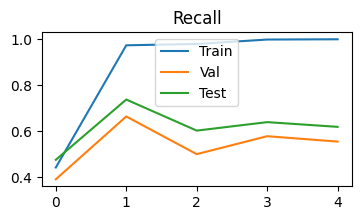

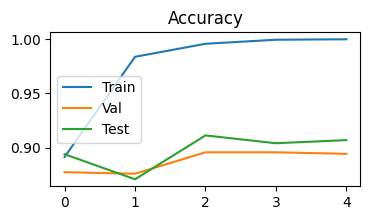

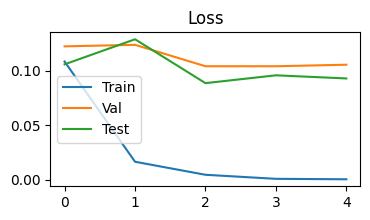

In [ ]:
df = load_data(train_df, val_df, test_df)
tokenized_datasets, model, data_collator = load_model("astarostap/autonlp-antisemitism-2-21194454")

train_dataloader, val_dataloader, test_dataloader, outputs = preprocess(tokenized_datasets, model, data_collator, 8)

num_epochs = 5
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps, lr_scheduler = set_params(train_dataloader, optimizer, num_epochs)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

train_recall, train_accuracy, train_loss, val_recall, val_accuracy, val_loss, test_recall, test_accuracy, test_loss, test_wrong_preds_list = train(train_dataloader, val_dataloader, test_dataloader, model, num_epochs, optimizer, lr_scheduler)

In [ ]:
print_metrics(train_recall, train_accuracy, train_loss, val_recall, val_accuracy, val_loss, test_recall, test_accuracy, test_loss)
print_wrong_preds(test_wrong_preds_list)

[0.4419134396355353, 0.9738041002277904, 0.979498861047836, 0.9988610478359908, 1.0]
[0.8915513323693451, 0.9836810576327205, 0.9956620532947738, 0.9993802933278249, 0.999793431109275]
[0.10844866763065482, 0.016318942367279488, 0.004337946705226193, 0.0006197066721751704, 0.0002065688907250568]
[0.390625, 0.6640625, 0.5, 0.578125, 0.5546875]
[0.8776371308016878, 0.8762306610407876, 0.8959212376933896, 0.8959212376933896, 0.8945147679324894]
[0.12236286919831224, 0.12376933895921238, 0.10407876230661041, 0.10407876230661041, 0.10548523206751055]
[0.47540983606557374, 0.7377049180327869, 0.6024590163934426, 0.639344262295082, 0.6188524590163934]
[0.8941684665226782, 0.871130309575234, 0.9114470842332614, 0.904247660187185, 0.9071274298056156]
[0.10583153347732181, 0.128869690424766, 0.08855291576673865, 0.09575233981281497, 0.09287257019438445]
Epoch 1:
BREAKING: We ran into @SenSchumer so we told him face to face: "New York Jews demand you stop funding the ethnic cleansing of Palestini

# Exploration: When does Model 2 performance worsen or improve?

## Tuning Hyperparameters

### Tuning Learning Rate

In [ ]:
def train_static_lr(train_dataloader, val_dataloader, test_dataloader, model, num_epochs, optimizer, lr_scheduler):
  progress_bar = tqdm(range(num_training_steps))

  train_recall_list = []
  train_accuracy_list = []
  train_loss_list = []
  val_recall_list = []
  val_accuracy_list = []
  val_loss_list = []
  test_recall_list = []
  test_accuracy_list = []
  test_loss_list = []
  train_wrong_preds_list = []
  val_wrong_preds_list = []
  test_wrong_preds_list = []


  start = time.time()
  model.train()
  for epoch in range(num_epochs):
    for batch in train_dataloader:
      batch = {k: v.to(device) for k, v in batch.items()} #selecting the batch
      outputs = model(**batch) #inputting batch into model
      loss = outputs.loss
      loss.backward()

      optimizer.step()
      optimizer.zero_grad()
      progress_bar.update(1)

    train_recall, train_accuracy, train_loss, train_wrong_preds = evaluate_acc(model, train_dataloader)
    val_recall, val_accuracy, val_loss, val_wrong_preds = evaluate_acc(model, val_dataloader)
    test_recall, test_accuracy, test_loss, test_wrong_preds = evaluate_acc(model, test_dataloader)

    train_recall_list.append(train_recall)
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)

    val_recall_list.append(val_recall)
    val_accuracy_list.append(val_accuracy)
    val_loss_list.append(val_loss)

    test_recall_list.append(test_recall)
    test_accuracy_list.append(test_accuracy)
    test_loss_list.append(test_loss)

    train_wrong_preds_list.append(train_wrong_preds)
    val_wrong_preds_list.append(val_wrong_preds)
    test_wrong_preds_list.append(test_wrong_preds)

    print(f"| epoch {epoch:2d} | train acc {train_accuracy} | val acc {val_accuracy} | test acc {test_accuracy} |")

  end = time.time()
  runtime = end-start
  print('Total runtime for ', num_epochs, ' epochs: ', runtime)

  train_recall = convert_performance_list(train_recall_list)
  train_accuracy = convert_performance_list(train_accuracy_list)
  train_loss = convert_performance_list(train_loss_list)
  val_recall = convert_performance_list(val_recall_list)
  val_accuracy = convert_performance_list(val_accuracy_list)
  val_loss = convert_performance_list(val_loss_list)
  test_recall = convert_performance_list(test_recall_list)
  test_accuracy = convert_performance_list(test_accuracy_list)
  test_loss = convert_performance_list(test_loss_list)

  plot_performance(num_epochs, train_recall, val_recall, test_recall, train_accuracy, val_accuracy, test_accuracy, train_loss, val_loss, test_loss)
  return train_recall, train_accuracy, train_loss, val_recall, val_accuracy, val_loss, test_recall, test_accuracy, test_loss, test_wrong_preds_list



DatasetDict({
    train: Dataset({
        features: ['label', 'Text', '__index_level_0__'],
        num_rows: 4841
    })
    test: Dataset({
        features: ['label', 'Text', '__index_level_0__'],
        num_rows: 1389
    })
    val: Dataset({
        features: ['label', 'Text', '__index_level_0__'],
        num_rows: 711
    })
})
DatasetDict({
    train: Dataset({
        features: ['label', 'Text'],
        num_rows: 4841
    })
    test: Dataset({
        features: ['label', 'Text'],
        num_rows: 1389
    })
    val: Dataset({
        features: ['label', 'Text'],
        num_rows: 711
    })
})


Map:   0%|          | 0/4841 [00:00<?, ? examples/s]

Map:   0%|          | 0/1389 [00:00<?, ? examples/s]

Map:   0%|          | 0/711 [00:00<?, ? examples/s]

tensor(0.5265, grad_fn=<NllLossBackward0>) torch.Size([8, 2])
3030


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/3030 [00:00<?, ?it/s]

| epoch  0 | train acc {'accuracy': 0.8095434827514977} | val acc {'accuracy': 0.8143459915611815} | test acc {'accuracy': 0.816414686825054} |
| epoch  1 | train acc {'accuracy': 0.8163602561454245} | val acc {'accuracy': 0.8171589310829818} | test acc {'accuracy': 0.822174226061915} |
| epoch  2 | train acc {'accuracy': 0.8231770295393513} | val acc {'accuracy': 0.819971870604782} | test acc {'accuracy': 0.8293736501079914} |
| epoch  3 | train acc {'accuracy': 0.8337120429663293} | val acc {'accuracy': 0.8340365682137834} | test acc {'accuracy': 0.8408927285817135} |
| epoch  4 | train acc {'accuracy': 0.8411485230324313} | val acc {'accuracy': 0.8438818565400844} | test acc {'accuracy': 0.8444924406047516} |
Total runtime for  5  epochs:  739.6979007720947


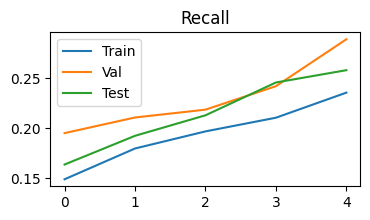

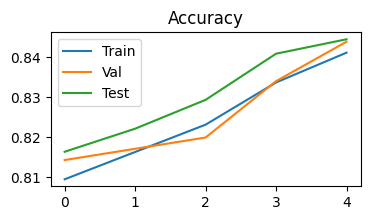

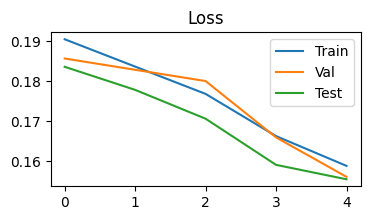

[0.1492027334851936, 0.17995444191343962, 0.1970387243735763, 0.21070615034168566, 0.2357630979498861]
[0.8095434827514977, 0.8163602561454245, 0.8231770295393513, 0.8337120429663293, 0.8411485230324313]
[0.19045651724850238, 0.1836397438545755, 0.17682297046064863, 0.16628795703367072, 0.15885147696756868]
[0.1953125, 0.2109375, 0.21875, 0.2421875, 0.2890625]
[0.8143459915611815, 0.8171589310829818, 0.819971870604782, 0.8340365682137834, 0.8438818565400844]
[0.18565400843881857, 0.1828410689170183, 0.180028129395218, 0.1659634317862166, 0.15611814345991562]
[0.16393442622950818, 0.19262295081967212, 0.21311475409836064, 0.2459016393442623, 0.2581967213114754]
[0.816414686825054, 0.822174226061915, 0.8293736501079914, 0.8408927285817135, 0.8444924406047516]
[0.183585313174946, 0.17782577393808496, 0.17062634989200864, 0.15910727141828654, 0.15550755939524838]
3030


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/3030 [00:00<?, ?it/s]

| epoch  0 | train acc {'accuracy': 0.9310059904978311} | val acc {'accuracy': 0.9015471167369902} | test acc {'accuracy': 0.9028077753779697} |
| epoch  1 | train acc {'accuracy': 0.9832679198512704} | val acc {'accuracy': 0.8748241912798875} | test acc {'accuracy': 0.8912886969042476} |
| epoch  2 | train acc {'accuracy': 0.992770088824623} | val acc {'accuracy': 0.8748241912798875} | test acc {'accuracy': 0.8776097912167027} |
| epoch  3 | train acc {'accuracy': 0.9983474488741996} | val acc {'accuracy': 0.8931082981715893} | test acc {'accuracy': 0.9013678905687545} |
| epoch  4 | train acc {'accuracy': 0.996281759966949} | val acc {'accuracy': 0.90014064697609} | test acc {'accuracy': 0.9078473722102232} |
Total runtime for  5  epochs:  739.1792209148407


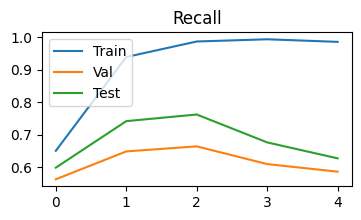

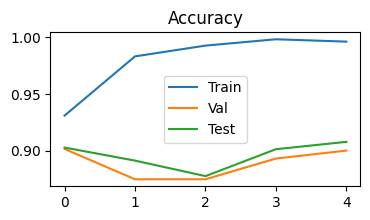

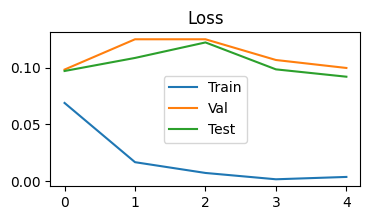

[0.6503416856492027, 0.9396355353075171, 0.9874715261958997, 0.9943052391799544, 0.9863325740318907]
[0.9310059904978311, 0.9832679198512704, 0.992770088824623, 0.9983474488741996, 0.996281759966949]
[0.06899400950216897, 0.0167320801487296, 0.007229911175376988, 0.0016525511258004544, 0.0037182400330510227]
[0.5625, 0.6484375, 0.6640625, 0.609375, 0.5859375]
[0.9015471167369902, 0.8748241912798875, 0.8748241912798875, 0.8931082981715893, 0.90014064697609]
[0.09845288326300984, 0.12517580872011252, 0.12517580872011252, 0.10689170182841069, 0.09985935302390998]
[0.5983606557377049, 0.7418032786885246, 0.7622950819672131, 0.6762295081967213, 0.6270491803278688]
[0.9028077753779697, 0.8912886969042476, 0.8776097912167027, 0.9013678905687545, 0.9078473722102232]
[0.09719222462203024, 0.10871130309575235, 0.12239020878329733, 0.09863210943124551, 0.09215262778977681]
3030


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/3030 [00:00<?, ?it/s]

| epoch  0 | train acc {'accuracy': 0.8186325139434001} | val acc {'accuracy': 0.819971870604782} | test acc {'accuracy': 0.8243340532757379} |
| epoch  1 | train acc {'accuracy': 0.18136748605659989} | val acc {'accuracy': 0.180028129395218} | test acc {'accuracy': 0.17566594672426206} |
| epoch  2 | train acc {'accuracy': 0.8186325139434001} | val acc {'accuracy': 0.819971870604782} | test acc {'accuracy': 0.8243340532757379} |
| epoch  3 | train acc {'accuracy': 0.8186325139434001} | val acc {'accuracy': 0.819971870604782} | test acc {'accuracy': 0.8243340532757379} |
| epoch  4 | train acc {'accuracy': 0.8186325139434001} | val acc {'accuracy': 0.819971870604782} | test acc {'accuracy': 0.8243340532757379} |
Total runtime for  5  epochs:  691.4658253192902


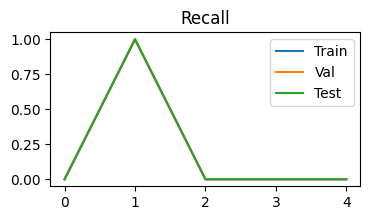

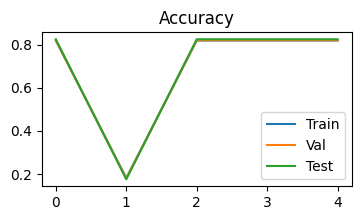

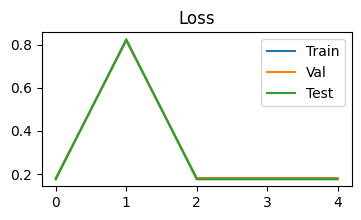

[0.0, 1.0, 0.0, 0.0, 0.0]
[0.8186325139434001, 0.18136748605659989, 0.8186325139434001, 0.8186325139434001, 0.8186325139434001]
[0.18136748605659989, 0.8186325139434001, 0.18136748605659989, 0.18136748605659989, 0.18136748605659989]
[0.0, 1.0, 0.0, 0.0, 0.0]
[0.819971870604782, 0.180028129395218, 0.819971870604782, 0.819971870604782, 0.819971870604782]
[0.180028129395218, 0.819971870604782, 0.180028129395218, 0.180028129395218, 0.180028129395218]
[0.0, 1.0, 0.0, 0.0, 0.0]
[0.8243340532757379, 0.17566594672426206, 0.8243340532757379, 0.8243340532757379, 0.8243340532757379]
[0.17566594672426206, 0.8243340532757379, 0.17566594672426206, 0.17566594672426206, 0.17566594672426206]


In [ ]:
#static learning rates
df = load_data(train_df, val_df, test_df)
tokenized_datasets, model, data_collator = load_model("astarostap/autonlp-antisemitism-2-21194454")
train_dataloader, val_dataloader, test_dataloader, outputs = preprocess(tokenized_datasets, model, data_collator, 8)
for i in [0.0000001, 0.00001, 0.1]:
  num_epochs = 5
  optimizer = AdamW(model.parameters(), lr=i)
  num_training_steps, lr_scheduler = set_params(train_dataloader, optimizer, num_epochs)

  device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
  model.to(device)
  device

  train_recall, train_accuracy, train_loss, val_recall, val_accuracy, val_loss, test_recall, test_accuracy, test_loss, test_wrong_preds = train_static_lr(train_dataloader, val_dataloader, test_dataloader, model, num_epochs, optimizer, lr_scheduler)
  print_metrics(train_recall, train_accuracy, train_loss, val_recall, val_accuracy, val_loss, test_recall, test_accuracy, test_loss)

### Tuning Batch Size

DatasetDict({
    train: Dataset({
        features: ['label', 'Text', '__index_level_0__'],
        num_rows: 4841
    })
    test: Dataset({
        features: ['label', 'Text', '__index_level_0__'],
        num_rows: 1389
    })
    val: Dataset({
        features: ['label', 'Text', '__index_level_0__'],
        num_rows: 711
    })
})
DatasetDict({
    train: Dataset({
        features: ['label', 'Text'],
        num_rows: 4841
    })
    test: Dataset({
        features: ['label', 'Text'],
        num_rows: 1389
    })
    val: Dataset({
        features: ['label', 'Text'],
        num_rows: 711
    })
})


Map:   0%|          | 0/4841 [00:00<?, ? examples/s]

Map:   0%|          | 0/1389 [00:00<?, ? examples/s]

Map:   0%|          | 0/711 [00:00<?, ? examples/s]

tensor(0.3422, grad_fn=<NllLossBackward0>) torch.Size([30, 2])
810


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/810 [00:00<?, ?it/s]

| epoch  0 | train acc {'accuracy': 0.9326585416236315} | val acc {'accuracy': 0.8959212376933896} | test acc {'accuracy': 0.9107271418286537} |
| epoch  1 | train acc {'accuracy': 0.9884321421193968} | val acc {'accuracy': 0.9057665260196905} | test acc {'accuracy': 0.9071274298056156} |
| epoch  2 | train acc {'accuracy': 0.9985540177649246} | val acc {'accuracy': 0.8959212376933896} | test acc {'accuracy': 0.8977681785457163} |
| epoch  3 | train acc {'accuracy': 0.9995868622185499} | val acc {'accuracy': 0.9085794655414908} | test acc {'accuracy': 0.9150467962562995} |
| epoch  4 | train acc {'accuracy': 0.999793431109275} | val acc {'accuracy': 0.9085794655414908} | test acc {'accuracy': 0.9150467962562995} |
Total runtime for  5  epochs:  808.3974299430847


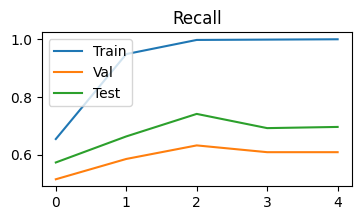

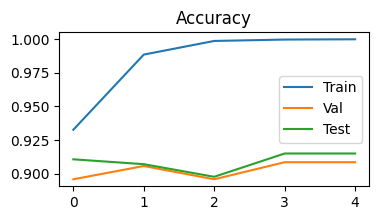

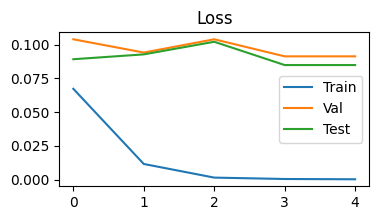

[0.6548974943052391, 0.94874715261959, 0.9977220956719818, 0.9988610478359908, 1.0]
[0.9326585416236315, 0.9884321421193968, 0.9985540177649246, 0.9995868622185499, 0.999793431109275]
[0.06734145837636851, 0.011567857880603181, 0.0014459822350753977, 0.0004131377814501136, 0.0002065688907250568]
[0.515625, 0.5859375, 0.6328125, 0.609375, 0.609375]
[0.8959212376933896, 0.9057665260196905, 0.8959212376933896, 0.9085794655414908, 0.9085794655414908]
[0.10407876230661041, 0.09423347398030943, 0.10407876230661041, 0.09142053445850915, 0.09142053445850915]
[0.5737704918032787, 0.6639344262295082, 0.7418032786885246, 0.6926229508196722, 0.6967213114754098]
[0.9107271418286537, 0.9071274298056156, 0.8977681785457163, 0.9150467962562995, 0.9150467962562995]
[0.0892728581713463, 0.09287257019438445, 0.10223182145428365, 0.08495320374370051, 0.08495320374370051]
DatasetDict({
    train: Dataset({
        features: ['label', 'Text', '__index_level_0__'],
        num_rows: 4841
    })
    test: Dat

Map:   0%|          | 0/4841 [00:00<?, ? examples/s]

Map:   0%|          | 0/1389 [00:00<?, ? examples/s]

Map:   0%|          | 0/711 [00:00<?, ? examples/s]

In [ ]:
# Our model crashed with batch size 100.
for i in [30,100]:
  df = load_data(train_df, val_df, test_df)
  tokenized_datasets, model, data_collator = load_model("astarostap/autonlp-antisemitism-2-21194454")
  train_dataloader, val_dataloader, test_dataloader, outputs = preprocess(tokenized_datasets, model, data_collator, i)

  num_epochs = 5
  optimizer = AdamW(model.parameters(), lr=5e-5)
  num_training_steps, lr_scheduler = set_params(train_dataloader, optimizer, num_epochs)

  device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
  model.to(device)
  device

  train_recall, train_accuracy, train_loss, val_recall, val_accuracy, val_loss, test_recall, test_accuracy, test_loss, test_wrong_preds_list = train(train_dataloader, val_dataloader, test_dataloader, model, num_epochs, optimizer, lr_scheduler)
  print_metrics(train_recall, train_accuracy, train_loss, val_recall, val_accuracy, val_loss, test_recall, test_accuracy, test_loss)

### Tuning Optimizer

DatasetDict({
    train: Dataset({
        features: ['label', 'Text', '__index_level_0__'],
        num_rows: 4841
    })
    test: Dataset({
        features: ['label', 'Text', '__index_level_0__'],
        num_rows: 1389
    })
    val: Dataset({
        features: ['label', 'Text', '__index_level_0__'],
        num_rows: 711
    })
})
DatasetDict({
    train: Dataset({
        features: ['label', 'Text'],
        num_rows: 4841
    })
    test: Dataset({
        features: ['label', 'Text'],
        num_rows: 1389
    })
    val: Dataset({
        features: ['label', 'Text'],
        num_rows: 711
    })
})


Map:   0%|          | 0/4841 [00:00<?, ? examples/s]

Map:   0%|          | 0/1389 [00:00<?, ? examples/s]

Map:   0%|          | 0/711 [00:00<?, ? examples/s]

tensor(0.5381, grad_fn=<NllLossBackward0>) torch.Size([8, 2])
3030


  0%|          | 0/3030 [00:00<?, ?it/s]

| epoch  0 | train acc {'accuracy': 0.8083040694071473} | val acc {'accuracy': 0.810126582278481} | test acc {'accuracy': 0.8156947444204463} |
| epoch  1 | train acc {'accuracy': 0.8120223094401983} | val acc {'accuracy': 0.810126582278481} | test acc {'accuracy': 0.8178545716342692} |
| epoch  2 | train acc {'accuracy': 0.814294567238174} | val acc {'accuracy': 0.8157524613220816} | test acc {'accuracy': 0.8200143988480921} |
| epoch  3 | train acc {'accuracy': 0.8153274116917992} | val acc {'accuracy': 0.8171589310829818} | test acc {'accuracy': 0.822174226061915} |
| epoch  4 | train acc {'accuracy': 0.8159471183639744} | val acc {'accuracy': 0.8171589310829818} | test acc {'accuracy': 0.822174226061915} |
Total runtime for  5  epochs:  678.2927882671356


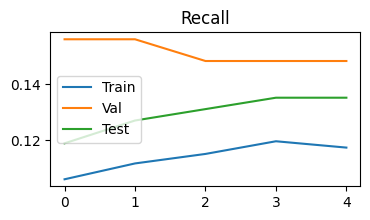

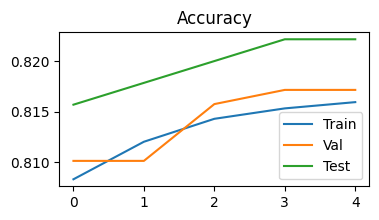

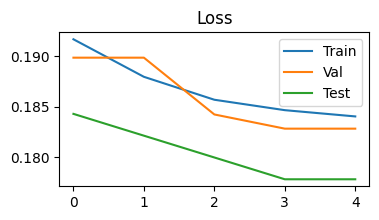

[0.10592255125284739, 0.11161731207289294, 0.11503416856492027, 0.11958997722095673, 0.11731207289293849]
[0.8083040694071473, 0.8120223094401983, 0.814294567238174, 0.8153274116917992, 0.8159471183639744]
[0.19169593059285273, 0.18797769055980168, 0.18570543276182608, 0.1846725883082008, 0.18405288163602562]
[0.15625, 0.15625, 0.1484375, 0.1484375, 0.1484375]
[0.810126582278481, 0.810126582278481, 0.8157524613220816, 0.8171589310829818, 0.8171589310829818]
[0.189873417721519, 0.189873417721519, 0.18424753867791843, 0.1828410689170183, 0.1828410689170183]
[0.11885245901639344, 0.12704918032786885, 0.13114754098360656, 0.13524590163934427, 0.13524590163934427]
[0.8156947444204463, 0.8178545716342692, 0.8200143988480921, 0.822174226061915, 0.822174226061915]
[0.18430525557955363, 0.18214542836573075, 0.17998560115190784, 0.17782577393808496, 0.17782577393808496]


In [ ]:
df = load_data(train_df, val_df, test_df)
tokenized_datasets, model, data_collator = load_model("astarostap/autonlp-antisemitism-2-21194454")
train_dataloader, val_dataloader, test_dataloader, outputs = preprocess(tokenized_datasets, model, data_collator, 8)

num_epochs = 5
optimizer = torch.optim.SGD(model.parameters(), lr=5e-5)
num_training_steps, lr_scheduler = set_params(train_dataloader, optimizer, num_epochs)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

train_recall, train_accuracy, train_loss, val_recall, val_accuracy, val_loss, test_recall, test_accuracy, test_loss, test_wrong_preds_list = train(train_dataloader, val_dataloader, test_dataloader, model, num_epochs, optimizer, lr_scheduler)
print_metrics(train_recall, train_accuracy, train_loss, val_recall, val_accuracy, val_loss, test_recall, test_accuracy, test_loss)

## Data Exploration: Datasets

In [ ]:
# Mount your own google drive to Colab
from google.colab import drive
drive.mount('/content/gdrive')
import sys, csv, pandas as pd

sys.path.append('/content/drive/MyDrive/PSYCH186B/FINAL_PROJECT/PSYCH_186B_Final_Project_Detecting_Antisemitism_Online/Jupyter_notebooks_of_github_files')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### SBIC: Jewish Only

In [ ]:
raw_datasets_train = pd.read_csv('/content/gdrive/MyDrive/PSYCH_186B_Final_Project_Detecting_Antisemitism_Online/SBIC_Datasets/Jewish_SBIC_subset/SBIC_jewish_train.csv')
raw_datasets_test = pd.read_csv('/content/gdrive/MyDrive/PSYCH_186B_Final_Project_Detecting_Antisemitism_Online/SBIC_Datasets/Jewish_SBIC_subset/SBIC_jewish_test.csv')

In [ ]:
#data preprocessing and cleaning
raw_datasets_train = raw_datasets_train[raw_datasets_train['offensiveYN'] != 0.5]
raw_datasets_test = raw_datasets_test[raw_datasets_test['offensiveYN'] != 0.5]
raw_datasets_train['offensiveYN'] = raw_datasets_train['offensiveYN'].astype(int)
raw_datasets_test['offensiveYN'] = raw_datasets_test['offensiveYN'].astype(int)
train_df = pd.DataFrame({'label': raw_datasets_train['offensiveYN'], 'Text': raw_datasets_train['post']})
test_df = pd.DataFrame({'label': raw_datasets_test['offensiveYN'], 'Text': raw_datasets_test['post']})
train_df, test_df

(      label                                               Text
 0         0  i hate when people say hitler did nothing wron...
 1         0  i hate when people say hitler did nothing wron...
 118       1  RT @BenjaminNorton: Remember the "yellow badge...
 119       1  RT @BenjaminNorton: Remember the "yellow badge...
 120       1  And the Jew @Deuterostomes favorited my tweet ...
 ...     ...                                                ...
 3939      1  Is the current state of female hypersexuality ...
 3940      1  I dont like Hitler but\nat least in their worl...
 3941      1  I dont like Hitler but\nat least in their worl...
 3942      1  Shower Thought: Telling us to respect women is...
 3943      1  Shower Thought: Telling us to respect women is...
 
 [3828 rows x 2 columns],
       label                                               Text
 26        1  @StanleyStinks Shame of you! Self-hating kike....
 27        1  @StanleyStinks Shame of you! Self-hating kike....
 28        1

In [ ]:
train_df, val_df = train_test_split(train_df, test_size = 0.128, random_state = 42)

DatasetDict({
    train: Dataset({
        features: ['label', 'Text', '__index_level_0__'],
        num_rows: 3338
    })
    test: Dataset({
        features: ['label', 'Text', '__index_level_0__'],
        num_rows: 1095
    })
    val: Dataset({
        features: ['label', 'Text', '__index_level_0__'],
        num_rows: 490
    })
})
DatasetDict({
    train: Dataset({
        features: ['label', 'Text'],
        num_rows: 3338
    })
    test: Dataset({
        features: ['label', 'Text'],
        num_rows: 1095
    })
    val: Dataset({
        features: ['label', 'Text'],
        num_rows: 490
    })
})


Map:   0%|          | 0/3338 [00:00<?, ? examples/s]

Map:   0%|          | 0/1095 [00:00<?, ? examples/s]

Map:   0%|          | 0/490 [00:00<?, ? examples/s]

tensor(0.8733, grad_fn=<NllLossBackward0>) torch.Size([8, 2])
2090


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/2090 [00:00<?, ?it/s]

| epoch  0 | train acc {'accuracy': 0.9994008388256441} | val acc {'accuracy': 1.0} | test acc {'accuracy': 1.0} |
| epoch  1 | train acc {'accuracy': 0.9994008388256441} | val acc {'accuracy': 1.0} | test acc {'accuracy': 1.0} |
| epoch  2 | train acc {'accuracy': 1.0} | val acc {'accuracy': 1.0} | test acc {'accuracy': 1.0} |
| epoch  3 | train acc {'accuracy': 1.0} | val acc {'accuracy': 1.0} | test acc {'accuracy': 1.0} |
| epoch  4 | train acc {'accuracy': 1.0} | val acc {'accuracy': 1.0} | test acc {'accuracy': 1.0} |
Total runtime for  5  epochs:  342.0082800388336


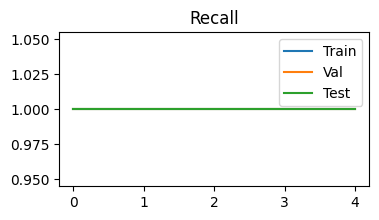

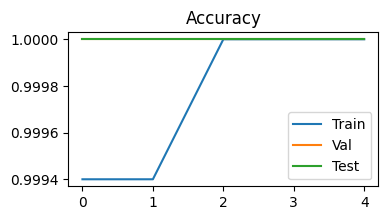

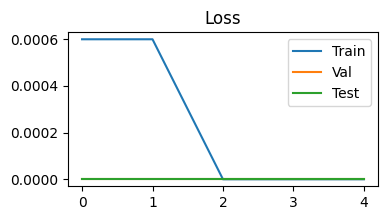

[1.0, 1.0, 1.0, 1.0, 1.0]
[0.9994008388256441, 0.9994008388256441, 1.0, 1.0, 1.0]
[0.0005991611743559018, 0.0005991611743559018, 0.0, 0.0, 0.0]
[1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0]
[0.0, 0.0, 0.0, 0.0, 0.0]
[1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0]
[0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
df = load_data(train_df, val_df, test_df)
tokenized_datasets, model, data_collator = load_model("astarostap/autonlp-antisemitism-2-21194454")

train_dataloader, val_dataloader, test_dataloader, outputs = preprocess(tokenized_datasets, model, data_collator, 8)

num_epochs = 5
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps, lr_scheduler = set_params(train_dataloader, optimizer, num_epochs)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

train_recall, train_accuracy, train_loss, val_recall, val_accuracy, val_loss, test_recall, test_accuracy, test_loss, test_wrong_preds_list = train(train_dataloader, val_dataloader, test_dataloader, model, num_epochs, optimizer, lr_scheduler)
print_metrics(train_recall, train_accuracy, train_loss, val_recall, val_accuracy, val_loss, test_recall, test_accuracy, test_loss)

### SBIC: Jewish vs All

In [ ]:
raw_datasets_train = pd.read_csv('/content/gdrive/MyDrive/PSYCH_186B_Final_Project_Detecting_Antisemitism_Online/SBIC_Datasets/FINAL_sbic_train_set.csv')
raw_datasets_test = pd.read_csv('/content/gdrive/MyDrive/PSYCH_186B_Final_Project_Detecting_Antisemitism_Online/SBIC_Datasets/FINAL_sbic_test_set.csv')

In [ ]:
train_df = pd.DataFrame({'label': raw_datasets_train['offensiveYN'], 'Text': raw_datasets_train['post']})
test_df = pd.DataFrame({'label': raw_datasets_test['offensiveYN'], 'Text': raw_datasets_test['post']})
train_df, test_df

(      label                                               Text
 0         0  @G_Anderson4 lol it's gonna be so fun got two ...
 1         0  Like the song French, "got all the black bitch...
 2         0  RT @prettykells: &#8220;@100046729: That's fuc...
 3         0  The people who have historically been called w...
 4         0                             Only bitches talk shit
 ...     ...                                                ...
 7595      0  If this gets 15 million upvotes in 3 minutes I...
 7596      0  If this gets 15 million upvotes in 3 minutes I...
 7597      0  tbh this sub made me more obsessed with women ...
 7598      0  Its so unfair, why can does everyone get to ha...
 7599      0  I deserve a girlfriend\nI have a job, go to sc...
 
 [7600 rows x 2 columns],
       label                                               Text
 0         0    RT @YoungAmari_: Dizzy bitch &#128530;&#128564;
 1         0  Like the hoes when they lay w/ me.. Puppy eyes...
 2         0

In [ ]:
# we see here that there is a perfectly even balance between posts that are anti-semitic
# and posts that are hateful towards any group but not antisemitic
np.unique(train_df['label'], return_counts = True), np.unique(test_df['label'], return_counts = True)

((array([0, 1]), array([3800, 3800])), (array([0, 1]), array([950, 950])))

In [ ]:
train_df, val_df = train_test_split(train_df, test_size = 0.128, random_state = 42)

DatasetDict({
    train: Dataset({
        features: ['label', 'Text', '__index_level_0__'],
        num_rows: 6627
    })
    test: Dataset({
        features: ['label', 'Text'],
        num_rows: 1900
    })
    val: Dataset({
        features: ['label', 'Text', '__index_level_0__'],
        num_rows: 973
    })
})
DatasetDict({
    train: Dataset({
        features: ['label', 'Text'],
        num_rows: 6627
    })
    test: Dataset({
        features: ['label', 'Text'],
        num_rows: 1900
    })
    val: Dataset({
        features: ['label', 'Text'],
        num_rows: 973
    })
})


Map:   0%|          | 0/6627 [00:00<?, ? examples/s]

Map:   0%|          | 0/1900 [00:00<?, ? examples/s]

Map:   0%|          | 0/973 [00:00<?, ? examples/s]

tensor(1.0309, grad_fn=<NllLossBackward0>) torch.Size([8, 2])
4145


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/4145 [00:00<?, ?it/s]

| epoch  0 | train acc {'accuracy': 0.9897389467330617} | val acc {'accuracy': 0.9845837615621789} | test acc {'accuracy': 0.9810526315789474} |
| epoch  1 | train acc {'accuracy': 0.99471857552437} | val acc {'accuracy': 0.9897225077081192} | test acc {'accuracy': 0.978421052631579} |
| epoch  2 | train acc {'accuracy': 0.995774860419496} | val acc {'accuracy': 0.9897225077081192} | test acc {'accuracy': 0.9789473684210527} |
| epoch  3 | train acc {'accuracy': 0.995774860419496} | val acc {'accuracy': 0.9897225077081192} | test acc {'accuracy': 0.9815789473684211} |
| epoch  4 | train acc {'accuracy': 0.9960766561038177} | val acc {'accuracy': 0.9886947584789312} | test acc {'accuracy': 0.9810526315789474} |
Total runtime for  5  epochs:  646.2248792648315


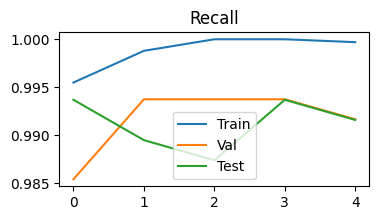

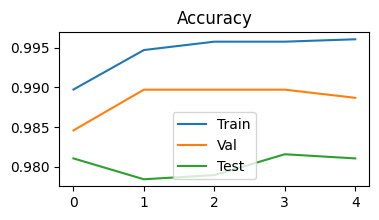

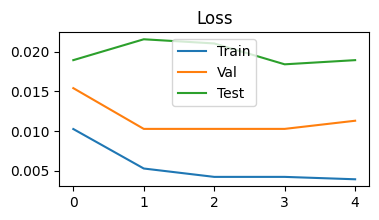

[0.995483288166215, 0.9987955435109906, 1.0, 1.0, 0.9996988858777477]
[0.9897389467330617, 0.99471857552437, 0.995774860419496, 0.995774860419496, 0.9960766561038177]
[0.010261053266938283, 0.005281424475629999, 0.004225139580503999, 0.004225139580503999, 0.003923343896182285]
[0.9853862212943633, 0.9937369519832986, 0.9937369519832986, 0.9937369519832986, 0.9916492693110647]
[0.9845837615621789, 0.9897225077081192, 0.9897225077081192, 0.9897225077081192, 0.9886947584789312]
[0.015416238437821172, 0.010277492291880781, 0.010277492291880781, 0.010277492291880781, 0.011305241521068859]
[0.9936842105263158, 0.9894736842105263, 0.9873684210526316, 0.9936842105263158, 0.991578947368421]
[0.9810526315789474, 0.978421052631579, 0.9789473684210527, 0.9815789473684211, 0.9810526315789474]
[0.018947368421052633, 0.02157894736842105, 0.021052631578947368, 0.018421052631578946, 0.018947368421052633]


In [ ]:
df = load_data(train_df, val_df, test_df)
tokenized_datasets, model, data_collator = load_model("astarostap/autonlp-antisemitism-2-21194454")

train_dataloader, val_dataloader, test_dataloader, outputs = preprocess(tokenized_datasets, model, data_collator, 8)

num_epochs = 5
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps, lr_scheduler = set_params(train_dataloader, optimizer, num_epochs)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

train_recall, train_accuracy, train_loss, val_recall, val_accuracy, val_loss, test_recall, test_accuracy, test_loss, test_wrong_preds_list = train(train_dataloader, val_dataloader, test_dataloader, model, num_epochs, optimizer, lr_scheduler)
print_metrics(train_recall, train_accuracy, train_loss, val_recall, val_accuracy, val_loss, test_recall, test_accuracy, test_loss)

### SBIC: Generalization

In [ ]:
raw_datasets_train = pd.read_csv('/content/gdrive/MyDrive/Psych186B/PSYCH_186B_Final_Project_Detecting_Antisemitism_Online/SBIC_Datasets/generalize_train.csv')
raw_datasets_test = pd.read_csv('/content/gdrive/MyDrive/Psych186B/PSYCH_186B_Final_Project_Detecting_Antisemitism_Online/SBIC_Datasets/generalize_test.csv')

In [ ]:
train_df = pd.DataFrame({'label': raw_datasets_train['offensiveYN'], 'Text': raw_datasets_train['post']})
test_df = pd.DataFrame({'label': raw_datasets_test['offensiveYN'], 'Text': raw_datasets_test['post']})
train_df, test_df

(      label                                               Text
 0         1  why do you duct tape a gerbil ? so it does n't...
 1         0             Not trying to be grammatically correct
 2         0  ".Can U say, ""I'm not aware of anything direc...
 3         0  Anyone else get a ridiculous sense of fate whe...
 4         1  "RT @Dussault_GLI: I'm sick of seeing ""i'm so...
 ...     ...                                                ...
 3995      1  Jesus was a carpenter But couldn't pull a nail...
 3996      1  Whichever it is this is utterly disgusting and...
 3997      0  Since I will be posting with the default text ...
 3998      1  &#8220;@FriendlyAssh0le: 5'3 200 lbs aint thic...
 3999      0  It is always nice to meet another person with ...
 
 [4000 rows x 2 columns],
      label                                               Text
 0        1  a black man with a parrot enters a bar the bar...
 1        0  Seeing a lot of talk about GDC vs PAX. I felt ...
 2        0  Al

In [ ]:
# we also see an even split here
np.unique(train_df['label'], return_counts = True), np.unique(test_df['label'], return_counts = True)

((array([0, 1]), array([2000, 2000])), (array([0, 1]), array([500, 500])))

In [ ]:
train_df, val_df = train_test_split(train_df, test_size = 0.128, random_state = 42)

DatasetDict({
    train: Dataset({
        features: ['label', 'Text', '__index_level_0__'],
        num_rows: 3488
    })
    test: Dataset({
        features: ['label', 'Text'],
        num_rows: 1000
    })
    val: Dataset({
        features: ['label', 'Text', '__index_level_0__'],
        num_rows: 512
    })
})
DatasetDict({
    train: Dataset({
        features: ['label', 'Text'],
        num_rows: 3488
    })
    test: Dataset({
        features: ['label', 'Text'],
        num_rows: 1000
    })
    val: Dataset({
        features: ['label', 'Text'],
        num_rows: 512
    })
})


config.json:   0%|          | 0.00/818 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/311 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/3488 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/512 [00:00<?, ? examples/s]

tensor(0.9426, grad_fn=<NllLossBackward0>) torch.Size([8, 2])
2180


  0%|          | 0/2180 [00:00<?, ?it/s]

| epoch  0 | train acc {'accuracy': 0.6522362385321101} | val acc {'accuracy': 0.638671875} | test acc {'accuracy': 0.672} |
| epoch  1 | train acc {'accuracy': 0.6642775229357798} | val acc {'accuracy': 0.646484375} | test acc {'accuracy': 0.687} |
| epoch  2 | train acc {'accuracy': 0.6700114678899083} | val acc {'accuracy': 0.654296875} | test acc {'accuracy': 0.687} |
| epoch  3 | train acc {'accuracy': 0.6748853211009175} | val acc {'accuracy': 0.66015625} | test acc {'accuracy': 0.688} |
| epoch  4 | train acc {'accuracy': 0.6757454128440367} | val acc {'accuracy': 0.662109375} | test acc {'accuracy': 0.689} |
Total runtime for  5  epochs:  302.14642667770386


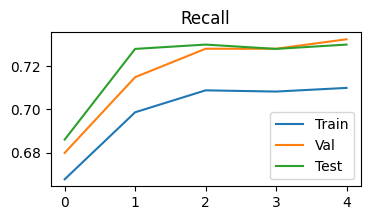

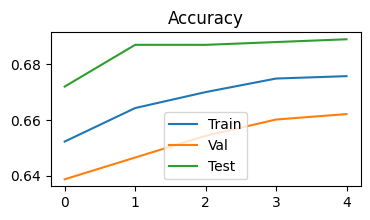

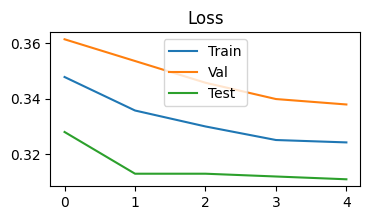

[0.667607223476298, 0.698645598194131, 0.708803611738149, 0.7082392776523702, 0.7099322799097065]
[0.6522362385321101, 0.6642775229357798, 0.6700114678899083, 0.6748853211009175, 0.6757454128440367]
[0.3477637614678899, 0.3357224770642202, 0.32998853211009177, 0.3251146788990826, 0.3242545871559633]
[0.6798245614035088, 0.7149122807017544, 0.7280701754385965, 0.7280701754385965, 0.7324561403508771]
[0.638671875, 0.646484375, 0.654296875, 0.66015625, 0.662109375]
[0.361328125, 0.353515625, 0.345703125, 0.33984375, 0.337890625]
[0.686, 0.728, 0.73, 0.728, 0.73]
[0.672, 0.687, 0.687, 0.688, 0.689]
[0.328, 0.313, 0.313, 0.312, 0.311]


In [ ]:
df = load_data(train_df, val_df, test_df)
tokenized_datasets, model, data_collator = load_model("astarostap/autonlp-antisemitism-2-21194454")
train_dataloader, val_dataloader, test_dataloader, outputs = preprocess(tokenized_datasets, model, data_collator, 8)

num_epochs = 5
optimizer = torch.optim.SGD(model.parameters(), lr=5e-5)
num_training_steps, lr_scheduler = set_params(train_dataloader, optimizer, num_epochs)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

train_recall, train_accuracy, train_loss, val_recall, val_accuracy, val_loss, test_recall, test_accuracy, test_loss, test_wrong_preds_list = train(train_dataloader, val_dataloader, test_dataloader, model, num_epochs, optimizer, lr_scheduler)
print_metrics(train_recall, train_accuracy, train_loss, val_recall, val_accuracy, val_loss, test_recall, test_accuracy, test_loss)

## Adding Modifications to Our Text

### Functions (Run This)

In [ ]:
lexicon = pd.read_csv('/content/gdrive/MyDrive/PSYCH_186B_Final_Project_Detecting_Antisemitism_Online/lexicon.csv')
lexicon = set(lexicon['Word'])
lexicon = {word.lower() for word in lexicon}
print(lexicon)

{'holocough', 'judeo-bolshevism', 'jew-down', 'kosher konsumer', 'jews pinocchio', 'zionazis', 'jew hooknose', 'jewish penny chaser', 'kosher tax', 'jew hebro', 'jews hebro', 'jews hooknose', 'jew penny chaser', 'yahoodi', 'jewish communism', 'snipcock', 'jews nickel nose', 'jewish lightning', 'kike', 'jew yorker', 'jewish controlled', '6mwe', 'nazionists', 'jew nickel nose', 'koshie', 'zionazi', 'jew pinocchio', 'jewmaican', 'ashkenazi', 'jews penny chaser', 'jewish hebro', 'protocols of the elders of zion', 'jewish money', 'jewpidity', 'jewish penny pincher', 'jew penny pincher', 'jewish nickel nose', 'jewbrew', 'christ killer', 'jews penny pincher', 'zog', 'fake jews', 'jewish hooknose', 'holohoax', 'jesus killer', 'bible shortener', 'jewish capitalism', 'morta cristo', 'jewish pinocchio'}


In [ ]:
def remove_word_jew(text):
    jewish_lexicon = ['jew', 'jewish', 'jews', 'judaism']
    text_lower = text.lower()
    for word in jewish_lexicon:
        # Replace the word with an empty string (case-insensitive)
        text_lower = text_lower.replace(word, '')
    return text_lower

In [ ]:
import random

def scramble(text):
    words = text.split()
    random.shuffle(words)
    return ' '.join(words)

In [ ]:
def remove(text):
    text = text.lower()
    # Iterate through each phrase in the lexicon
    for phrase in lexicon:
        # Check if the phrase is in the text
        text = text.replace(phrase, '')
    return text

In [ ]:
def newtest(new_df):
  combined_datasets = DatasetDict()
  # Create Datasets for train and test
  test_data = Dataset.from_pandas(new_df)

  combined_datasets['test'] = test_data
  if '__index_level_0__' in combined_datasets['test'].column_names:
    combined_datasets['test'] = combined_datasets['test'].remove_columns('__index_level_0__')

  tokenizer = AutoTokenizer.from_pretrained("astarostap/autonlp-antisemitism-2-21194454")
  def tokenize_function(example):
    return tokenizer(example["Text"], truncation=True)
  tokenized_datasets = combined_datasets['test'].map(tokenize_function, batched = True)
  data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  tokenized_datasets = tokenized_datasets.remove_columns(['Text'])
  tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
  tokenized_datasets.set_format("torch")

  test_dataloader = DataLoader(tokenized_datasets, batch_size=8, collate_fn=data_collator)

  test_recall, test_accuracy, test_loss, test_wrong_preds = evaluate_acc(model, test_dataloader)

  print(f"Recall: {test_recall} | Accuracy: {test_accuracy} | Loss: {test_loss}")

  test_wrong_preds = [test_wrong_preds]
  print_wrong_preds(test_wrong_preds)

  return

### Testing only with Scrambled Data

In [ ]:
test_df['Text']

4332    BREAKING: We ran into @SenSchumer so we told h...
6720    Third graders forced to dig pretend mass grave...
6780    @cashmoneyglock @CptBlackPill If I wear a suit...
6589    RT @End_TheFederalR: People tell me to hate th...
6566    @thehill Why, did she call the mass murder of ...
                              ...                        
33      “Right-wing and far-right movements and politi...
4990    Now israel plays the zioNAZI and kills their f...
44      IF they wanna intercept mortar shells, Iron Do...
3307    Ilhan Omar Introduces Resolution Condemning Ra...
3043    @icecube Cube, this is an Anti-Semitic trope. ...
Name: Text, Length: 1389, dtype: object

In [ ]:
test_scramble = test_df.copy(deep = True)
test_scramble['Text'] = test_scramble['Text'].apply(scramble)
test_scramble.head()

,label,Text
4332,1,of it. York into same want thing: tell stop th...
6720,0,graves https://t.co/nLppdupnOY to then Christm...
6780,1,"kikes, If stupid wear I @CptBlackPill heh� I a..."
6589,1,tell blame blame political label's hate I the ...
6566,0,think staged the that Does children forest did...


In [ ]:
newtest(test_scramble)

Map:   0%|          | 0/1389 [00:00<?, ? examples/s]

Recall: {'recall': 0.7090163934426229} | Accuracy: {'accuracy': 0.8560115190784737} | Loss: {'mse': 0.14398848092152627}
Epoch 1:
BREAKING: We ran into @SenSchumer so we told him face to face: "New York Jews demand you stop funding the ethnic cleansing of Palestinians." He didn't want to talk about it. Help us force him to. Call his office now and tell him the same thing: 212-486-4430. https://t.co/JRDuZAdmII
@cashmoneyglock @CptBlackPill If I wear a suit normie liberals will be stupid too figure out I hate the kikes, heh� https://t.co/epM9k8Oejf
RT @End_TheFederalR: People tell me to hate the Jews. I don't hate or blame the Jews. Jesus was Jewish. I blame label's and political movem�
@theipaper Yes, the anti-Semitism has gone right up with Keir Starmer's purging of hundreds of left-wing Jews from the party.\n\nLabour now have an official wrong kind of Jew policy.
@your_njg @EFalyer @levvity @Georgia85485397 Supremacism: Israeli Jews are treated very well in Israel while it tightly con

### Testing only without the word "Jew" or "Jewish"

In [ ]:
test_df['Text']

4332    BREAKING: We ran into @SenSchumer so we told h...
6720    Third graders forced to dig pretend mass grave...
6780    @cashmoneyglock @CptBlackPill If I wear a suit...
6589    RT @End_TheFederalR: People tell me to hate th...
6566    @thehill Why, did she call the mass murder of ...
                              ...                        
33      “Right-wing and far-right movements and politi...
4990    Now israel plays the zioNAZI and kills their f...
44      IF they wanna intercept mortar shells, Iron Do...
3307    Ilhan Omar Introduces Resolution Condemning Ra...
3043    @icecube Cube, this is an Anti-Semitic trope. ...
Name: Text, Length: 1389, dtype: object

In [ ]:
test_df['Text'][4332]

'BREAKING: We ran into @SenSchumer so we told him face to face: "New York Jews demand you stop funding the ethnic cleansing of Palestinians." He didn\'t want to talk about it. Help us force him to. Call his office now and tell him the same thing: 212-486-4430. https://t.co/JRDuZAdmII'

In [ ]:
test_remove_word_jew = test_df.copy(deep = True)
test_remove_word_jew['Text'] = test_remove_word_jew['Text'].apply(remove_word_jew)

In [ ]:
test_remove_word_jew['Text']

4332    breaking: we ran into @senschumer so we told h...
6720    third graders forced to dig pretend mass grave...
6780    @cashmoneyglock @cptblackpill if i wear a suit...
6589    rt @end_thefederalr: people tell me to hate th...
6566    @thehill why, did she call the mass murder of ...
                              ...                        
33      “right-wing and far-right movements and politi...
4990    now israel plays the zionazi and kills their f...
44      if they wanna intercept mortar shells, iron do...
3307    ilhan omar introduces resolution condemning ra...
3043    @icecube cube, this is an anti-semitic trope. ...
Name: Text, Length: 1389, dtype: object

In [ ]:
test_remove_word_jew['Text'][4332]

'breaking: we ran into @senschumer so we told him face to face: "new york s demand you stop funding the ethnic cleansing of palestinians." he didn\'t want to talk about it. help us force him to. call his office now and tell him the same thing: 212-486-4430. https://t.co/jrduzadmii'

In [ ]:
#correctly filtered out all words
filtered_df = test_remove_word_jew[test_remove_word_jew['Text'].str.contains('jew', case=False)]
filtered_df

,label,Text


In [ ]:
newtest(test_remove_word_jew)

Map:   0%|          | 0/1389 [00:00<?, ? examples/s]

Recall: {'recall': 0.7008196721311475} | Accuracy: {'accuracy': 0.8912886969042476} | Loss: {'mse': 0.10871130309575235}
Epoch 1:
BREAKING: We ran into @SenSchumer so we told him face to face: "New York Jews demand you stop funding the ethnic cleansing of Palestinians." He didn't want to talk about it. Help us force him to. Call his office now and tell him the same thing: 212-486-4430. https://t.co/JRDuZAdmII
RT @End_TheFederalR: People tell me to hate the Jews. I don't hate or blame the Jews. Jesus was Jewish. I blame label's and political movem�
@your_njg @EFalyer @levvity @Georgia85485397 Supremacism: Israeli Jews are treated very well in Israel while it tightly controls Palestine, allows very little immigration, destroys infrastructure, ghettoized East Jerusalem, prevents businesses from succeeding, bulldozes property and imprisons youth indefinitely &amp; repeatedly
@ymosko @mattgaetz @realDonaldTrump Not all Jews.
"In this country, the blacks vote black. The Jews vote Jewish. Onl

### Testing only without words from the antisemitism lexicon

In [ ]:
test_df['Text'][4990]

'Now israel plays the zioNAZI and kills their former hosts, the Palestinians https://t.co/zhzQw9iKML'

In [ ]:
# Apply the function to remove phrases from the 'Text' column
test_remove = test_df.copy(deep = True)
test_remove['Text'] = test_remove['Text'].apply(remove)
test_remove['Text'][4990]

'now israel plays the  and kills their former hosts, the palestinians https://t.co/zhzqw9ikml'

In [ ]:
newtest(test_remove)

Map:   0%|          | 0/1389 [00:00<?, ? examples/s]

Recall: {'recall': 0.42213114754098363} | Accuracy: {'accuracy': 0.86321094312455} | Loss: {'mse': 0.13678905687544995}
Epoch 1:
BREAKING: We ran into @SenSchumer so we told him face to face: "New York Jews demand you stop funding the ethnic cleansing of Palestinians." He didn't want to talk about it. Help us force him to. Call his office now and tell him the same thing: 212-486-4430. https://t.co/JRDuZAdmII
@cashmoneyglock @CptBlackPill If I wear a suit normie liberals will be stupid too figure out I hate the kikes, heh� https://t.co/epM9k8Oejf
RT @End_TheFederalR: People tell me to hate the Jews. I don't hate or blame the Jews. Jesus was Jewish. I blame label's and political movem�
Genocide - Free Palestine https://t.co/1noNGn0srJ  Zionazis in the holy land need to get out. Ppl want peace &amp; Pale� https://t.co/92S9jkMUIF
@your_njg @EFalyer @levvity @Georgia85485397 Supremacism: Israeli Jews are treated very well in Israel while it tightly controls Palestine, allows very little imm

## Adding Modifications to Our Text with the SBIC Dataset
Intuition: Since the SBIC dataset seems to be more extreme and loaded with explicitly antisemitic texts, will the performance model change if we remove explicit slurs?

### Loading in the data

In [ ]:
raw_datasets_test = pd.read_csv('/content/gdrive/MyDrive/PSYCH_186B_Final_Project_Detecting_Antisemitism_Online/SBIC_Datasets/FINAL_sbic_test_set.csv')

In [ ]:
lexicon = pd.read_csv('/content/gdrive/MyDrive/PSYCH_186B_Final_Project_Detecting_Antisemitism_Online/lexicon.csv')

lexicon = set(lexicon['Word'])
lexicon = {word.lower() for word in lexicon}
print(lexicon)

{'holocough', 'judeo-bolshevism', 'jew-down', 'kosher konsumer', 'jews pinocchio', 'zionazis', 'jew hooknose', 'jewish penny chaser', 'kosher tax', 'jew hebro', 'jews hebro', 'jews hooknose', 'jew penny chaser', 'yahoodi', 'jewish communism', 'snipcock', 'jews nickel nose', 'jewish lightning', 'kike', 'jew yorker', 'jewish controlled', '6mwe', 'nazionists', 'jew nickel nose', 'koshie', 'zionazi', 'jew pinocchio', 'jewmaican', 'ashkenazi', 'jews penny chaser', 'jewish hebro', 'protocols of the elders of zion', 'jewish money', 'jewpidity', 'jewish penny pincher', 'jew penny pincher', 'jewish nickel nose', 'jewbrew', 'christ killer', 'jews penny pincher', 'zog', 'fake jews', 'jewish hooknose', 'holohoax', 'jesus killer', 'bible shortener', 'jewish capitalism', 'morta cristo', 'jewish pinocchio'}


In [ ]:
test_df = pd.DataFrame({'label': raw_datasets_test['offensiveYN'], 'Text': raw_datasets_test['post']})

In [ ]:
def remove_word_jew(text):
    jewish_lexicon = ['jew', 'jewish', 'jews', 'judaism']
    text_lower = text.lower()
    for word in jewish_lexicon:
        # Replace the word with an empty string (case-insensitive)
        text_lower = text_lower.replace(word, '')
    return text_lower

In [ ]:
def remove(text):
    text = text.lower()
    # Iterate through each phrase in the lexicon
    for phrase in lexicon:
        # Check if the phrase is in the text
        text = text.replace(phrase, '')
    return text

### Testing only without the word "Jew" on the SBIC Dataset

In [ ]:
test_df['Text']

0         RT @YoungAmari_: Dizzy bitch &#128530;&#128564;
1       Like the hoes when they lay w/ me.. Puppy eyes...
2       i ran out &#128553; RT @sadonna_rae: This hoe ...
3       "@ARIZZLEINDACUT: Females think dating a pussy...
4            Awwwwww they no Kaep ain't rape no bitch!!!!
                              ...                        
1895    A white male toddler needs to have its head sm...
1896    I'm sure if I'm an incel yet or not\nI got rat...
1897    If you became chad tier good looking through s...
1898    This guy has a chad jawline but is incel in ev...
1899    Minimum attractiveness to get women per height...
Name: Text, Length: 1900, dtype: object

In [ ]:
test_remove_word_jew_sbic = test_df.copy(deep = True)
test_remove_word_jew_sbic['Text'] = test_remove_word_jew_sbic['Text'].apply(remove_word_jew)

In [ ]:
newtest(test_remove_word_jew_sbic)

Map:   0%|          | 0/1900 [00:00<?, ? examples/s]

Recall: {'recall': 0.18842105263157893} | Accuracy: {'accuracy': 0.5184210526315789} | Loss: {'mse': 0.48157894736842105}
Epoch 1:
Awwwwww they no Kaep ain't rape no bitch!!!!
RT @HG_Shit: @1BookieG them klutzy bitches
@lucas_wright955 @MichaelGT03 faggots
Got a lil bitch from the 916
RT @useemitch: 1, 2, 3, 4... how many niggers are in my store, I knooooooow your stealing! &#128514;&#128514;&#128514;
RT @useemitch: 1, 2, 3, 4... how many niggers are in my store, I knooooooow your stealing! &#128514;&#128514;&#128514;
These fat hoes think they slick posting neck up pics and shit
I'm so tired of this damn job man, I wanna blow this bitch up lol
ain't trusting no bitch or no nigga... hoe or no sucka
Hoes gone be hoes but thats none my business !!
RT @Stuff4blackppl: Not basic bitches
dumb ugly stupid bullshit ass bitch &#128074;&#128074;&#128074;
You know a bitch mad when she throw her drink &#128514; now she got to find another nigga to buy her another one
RT @WayneL_Jr: 80% RT @NotMorr

### Testing only without words from the antisemitism lexicon on the SBIC dataset

In [ ]:
test_df['Text']

0         RT @YoungAmari_: Dizzy bitch &#128530;&#128564;
1       Like the hoes when they lay w/ me.. Puppy eyes...
2       i ran out &#128553; RT @sadonna_rae: This hoe ...
3       "@ARIZZLEINDACUT: Females think dating a pussy...
4            Awwwwww they no Kaep ain't rape no bitch!!!!
                              ...                        
1895    A white male toddler needs to have its head sm...
1896    I'm sure if I'm an incel yet or not\nI got rat...
1897    If you became chad tier good looking through s...
1898    This guy has a chad jawline but is incel in ev...
1899    Minimum attractiveness to get women per height...
Name: Text, Length: 1900, dtype: object

In [ ]:
test_remove = test_df.copy(deep = True)
test_remove['Text'] = test_remove['Text'].apply(remove)

In [ ]:
newtest(test_remove)

Map:   0%|          | 0/1900 [00:00<?, ? examples/s]

Recall: {'recall': 0.15368421052631578} | Accuracy: {'accuracy': 0.508421052631579} | Loss: {'mse': 0.49157894736842106}
Epoch 1:
Like the hoes when they lay w/ me.. Puppy eyes when I go, Sayin stay wit me
Awwwwww they no Kaep ain't rape no bitch!!!!
RT @HG_Shit: @1BookieG them klutzy bitches
@lucas_wright955 @MichaelGT03 faggots
RT @useemitch: 1, 2, 3, 4... how many niggers are in my store, I knooooooow your stealing! &#128514;&#128514;&#128514;
RT @useemitch: 1, 2, 3, 4... how many niggers are in my store, I knooooooow your stealing! &#128514;&#128514;&#128514;
I'm so tired of this damn job man, I wanna blow this bitch up lol
ain't trusting no bitch or no nigga... hoe or no sucka
Hoes gone be hoes but thats none my business !!
RT @Stuff4blackppl: Not basic bitches
RT @XdalovelyTishai: Most of these niggas go broke for these hoes
dumb ugly stupid bullshit ass bitch &#128074;&#128074;&#128074;
@freeyungnwild "bitches talk shit, you got the right to swerve" god damnit you are da shittt


# Model 3: Testing on a general hate speech classifier

In [ ]:
raw_datasets = load_dataset("ISCA-IUB/AntisemitismOnTwitter")

label = raw_datasets['train']['Biased']
text = raw_datasets['train']['Text']

df = pd.DataFrame({'label': label, 'Text': text})
df

,label,Text
0,0,The last 24 hours in Israel: https://t.co/0YNw...
1,0,@stranahan KnowMoreNews isn't confident enough...
2,0,"""[Even] an heritage unto Israel his servant: f..."
3,0,Opinion: No One in Israel Knew They Were Commi...
4,0,https://t.co/LTB0zidzM9 When #TheCloudOfGod ap...
...,...,...
6936,1,@JackieKane I'd never go back. ZioNazi managem...
6937,1,@JulianRoepcke The lovely Zionazi Djihad Julia...
6938,1,@IvankaTrump A zionazists Jews.
6939,1,"Mr. President, I this year you will lead the I..."


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size = 0.128, random_state = 42)

##  Will it perform better than the antisemitic model?

DatasetDict({
    train: Dataset({
        features: ['label', 'Text', '__index_level_0__'],
        num_rows: 4841
    })
    test: Dataset({
        features: ['label', 'Text', '__index_level_0__'],
        num_rows: 1389
    })
    val: Dataset({
        features: ['label', 'Text', '__index_level_0__'],
        num_rows: 711
    })
})
DatasetDict({
    train: Dataset({
        features: ['label', 'Text'],
        num_rows: 4841
    })
    test: Dataset({
        features: ['label', 'Text'],
        num_rows: 1389
    })
    val: Dataset({
        features: ['label', 'Text'],
        num_rows: 711
    })
})


config.json:   0%|          | 0.00/816 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Map:   0%|          | 0/4841 [00:00<?, ? examples/s]

Map:   0%|          | 0/1389 [00:00<?, ? examples/s]

Map:   0%|          | 0/711 [00:00<?, ? examples/s]

tensor(0.9126, grad_fn=<NllLossBackward0>) torch.Size([8, 2])
3030


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/3030 [00:00<?, ?it/s]

| epoch  0 | train acc {'accuracy': 0.905598016938649} | val acc {'accuracy': 0.890295358649789} | test acc {'accuracy': 0.9049676025917927} |
| epoch  1 | train acc {'accuracy': 0.8186325139434001} | val acc {'accuracy': 0.819971870604782} | test acc {'accuracy': 0.8243340532757379} |
| epoch  2 | train acc {'accuracy': 0.9809956620532948} | val acc {'accuracy': 0.9057665260196905} | test acc {'accuracy': 0.9114470842332614} |
| epoch  3 | train acc {'accuracy': 0.9940095021689733} | val acc {'accuracy': 0.9015471167369902} | test acc {'accuracy': 0.9100071994240461} |
| epoch  4 | train acc {'accuracy': 0.996488328857674} | val acc {'accuracy': 0.8945147679324894} | test acc {'accuracy': 0.9085673146148309} |
Total runtime for  5  epochs:  684.6942286491394


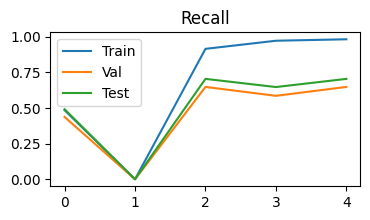

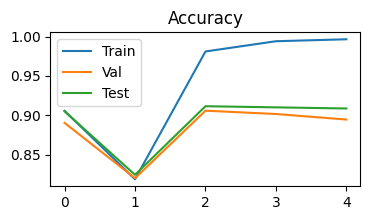

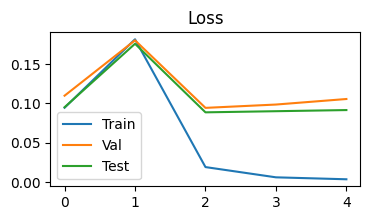

[0.48519362186788156, 0.0, 0.9157175398633257, 0.9726651480637813, 0.9829157175398633]
[0.905598016938649, 0.8186325139434001, 0.9809956620532948, 0.9940095021689733, 0.996488328857674]
[0.09440198306135096, 0.18136748605659989, 0.019004337946705228, 0.005990497831026648, 0.0035116711423259657]
[0.4375, 0.0, 0.6484375, 0.5859375, 0.6484375]
[0.890295358649789, 0.819971870604782, 0.9057665260196905, 0.9015471167369902, 0.8945147679324894]
[0.10970464135021098, 0.180028129395218, 0.09423347398030943, 0.09845288326300984, 0.10548523206751055]
[0.4918032786885246, 0.0, 0.7049180327868853, 0.6475409836065574, 0.7049180327868853]
[0.9049676025917927, 0.8243340532757379, 0.9114470842332614, 0.9100071994240461, 0.9085673146148309]
[0.09503239740820735, 0.17566594672426206, 0.08855291576673865, 0.08999280057595392, 0.09143268538516919]


In [ ]:
df = load_data(train_df, val_df, test_df)
tokenized_datasets, model, data_collator = load_model("facebook/roberta-hate-speech-dynabench-r4-target")

train_dataloader, val_dataloader, test_dataloader, outputs = preprocess(tokenized_datasets, model, data_collator, 8)

num_epochs = 5 #run with 5 to save time
optimizer = AdamW(model.parameters(), lr=5e-5)
num_training_steps, lr_scheduler = set_params(train_dataloader, optimizer, num_epochs)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

train_recall, train_accuracy, train_loss, val_recall, val_accuracy, val_loss, test_recall, test_accuracy, test_loss, test_wrong_preds_list = train(train_dataloader, val_dataloader, test_dataloader, model, num_epochs, optimizer, lr_scheduler)
print_metrics(train_recall, train_accuracy, train_loss, val_recall, val_accuracy, val_loss, test_recall, test_accuracy, test_loss)

In [ ]:
print_wrong_preds(test_wrong_preds_list)

Epoch 1:
BREAKING: We ran into @SenSchumer so we told him face to face: "New York Jews demand you stop funding the ethnic cleansing of Palestinians." He didn't want to talk about it. Help us force him to. Call his office now and tell him the same thing: 212-486-4430. https://t.co/JRDuZAdmII
@cashmoneyglock @CptBlackPill If I wear a suit normie liberals will be stupid too figure out I hate the kikes, heh� https://t.co/epM9k8Oejf
RT @End_TheFederalR: People tell me to hate the Jews. I don't hate or blame the Jews. Jesus was Jewish. I blame label's and political movem�
@your_njg @EFalyer @levvity @Georgia85485397 Supremacism: Israeli Jews are treated very well in Israel while it tightly controls Palestine, allows very little immigration, destroys infrastructure, ghettoized East Jerusalem, prevents businesses from succeeding, bulldozes property and imprisons youth indefinitely &amp; repeatedly
"In this country, the blacks vote black. The Jews vote Jewish. Only the White people are stupid e

## Can it distinguish between antisemitic data and hate speech in general?

In [ ]:
raw_datasets_test = pd.read_csv('/content/gdrive/MyDrive/PSYCH_186B_Final_Project_Detecting_Antisemitism_Online/SBIC_Datasets/FINAL_sbic_test_set.csv')
test_df = pd.DataFrame({'label': raw_datasets_test['offensiveYN'], 'Text': raw_datasets_test['post']})
newtest(test_df)

Map:   0%|          | 0/1900 [00:00<?, ? examples/s]

Recall: {'recall': 0.07052631578947369} | Accuracy: {'accuracy': 0.5126315789473684} | Loss: {'mse': 0.48736842105263156}
Epoch 1:
"or would you go and buy a car shrug your shoulders, say ""there you are she didn't love me anyway if she had she would have stayed"""
Waiting to get released from the emergency room ran test nothing show up but they know something wrong need go see a specialist
I refuse to alllow anybody's dirty ass daughter to get me outta character &#128557;&#128514;
if u need an update don't hesitate to msg me abt ur commission, i hope to finish them all this month. i nvr realize how fast time nyooms by
Sometimes you have to forgive &amp; forget. Forgive them for hurting and forget they even exist. #ALDUBKSGoesToUS
Man is playing football after a fucking leg break but Mourinho doesn't think he has the focus. Loooll. De Bruyne 2.0 incoming
Man is playing football after a fucking leg break but Mourinho doesn't think he has the focus. Loooll. De Bruyne 2.0 incoming
.@DEEPR